### 03 - Classification Head Baseline

Our core objective is to establish and validate Pipeline C, the Classification Head Baseline, tasked with detecting Meniscus Tears. This pipeline represents our fixed, high-quality measuring stick—the unbiased feature extraction oracle—against which all subsequent reconstruction experiments (Flows A1-C, A2-C, and B-C) will be benchmarked.

For its deep feature extractor, the model leverages a pretrained ResNet-18. This strategic use of transfer learning is crucial, as it provides an extremely high-quality feature space, refined over millions of previous images, while optimizing for our limited computational resources. We perform necessary surgical modifications: the ResNet-18's input layer is adapted to accept a single grayscale channel (our MRI data), and its final fully connected layer is replaced and retrained locally to output the two required labels (Tear or No Tear). Upon reaching optimal performance, the weights of the entire ResNet-18 feature extractor core are permanently frozen to ensure its neutrality and immutability as an evaluator.

In [ ]:
import sys
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

project_root = Path('..').resolve()
project_root_str = str(project_root)
if project_root_str not in sys.path:
    # Use insert(0) to ensure it's the first place Python checks
    sys.path.insert(0, project_root_str)
    print(f"Added '{project_root_str}' to sys.path.")
    
import importlib
import src.datasets 
import src.models
import src.evaluation_utilities
importlib.reload(src.datasets)
importlib.reload(src.models)
importlib.reload(src.evaluation_utilities)
from src.datasets import ClassificationDataset
from src.models import MeniscusTearModel, find_latest_checkpoint
from src.evaluation_utilities import *

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
train = False

Added 'C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow' to sys.path.


#### 3.1. Data Loading (Ground Truth Input)

The process begins by establishing the single source of truth. We utilize the specialized ClassificationDataset object to load the full-fidelity, fully-sampled images and their definitive, corresponding labels. These are the gold-standard data points for our task. Before training, we inspect and visualize a representative subset of this ground truth input. This crucial step is performed to gain a deeper, more intuitive understanding of the dataset's structural characteristics, noise profiles, and inherent classification difficulty, which sets the theoretical performance ceiling for all pipelines.

In [2]:
data_root = Path("../data/raw/singlecoil_val")
train_data_file = Path("../data/labels/train_data.csv")
val_data_file = Path("../data/labels/val_data.csv")
target_res= (250, 250)

train_dataset = ClassificationDataset(
    data_root = data_root,
    manifest_path = train_data_file, 
    target_resolution =  target_res)

val_dataset = ClassificationDataset(
    data_root = data_root,
    manifest_path = val_data_file, 
    target_resolution =  target_res)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1636 train images and 316 val images


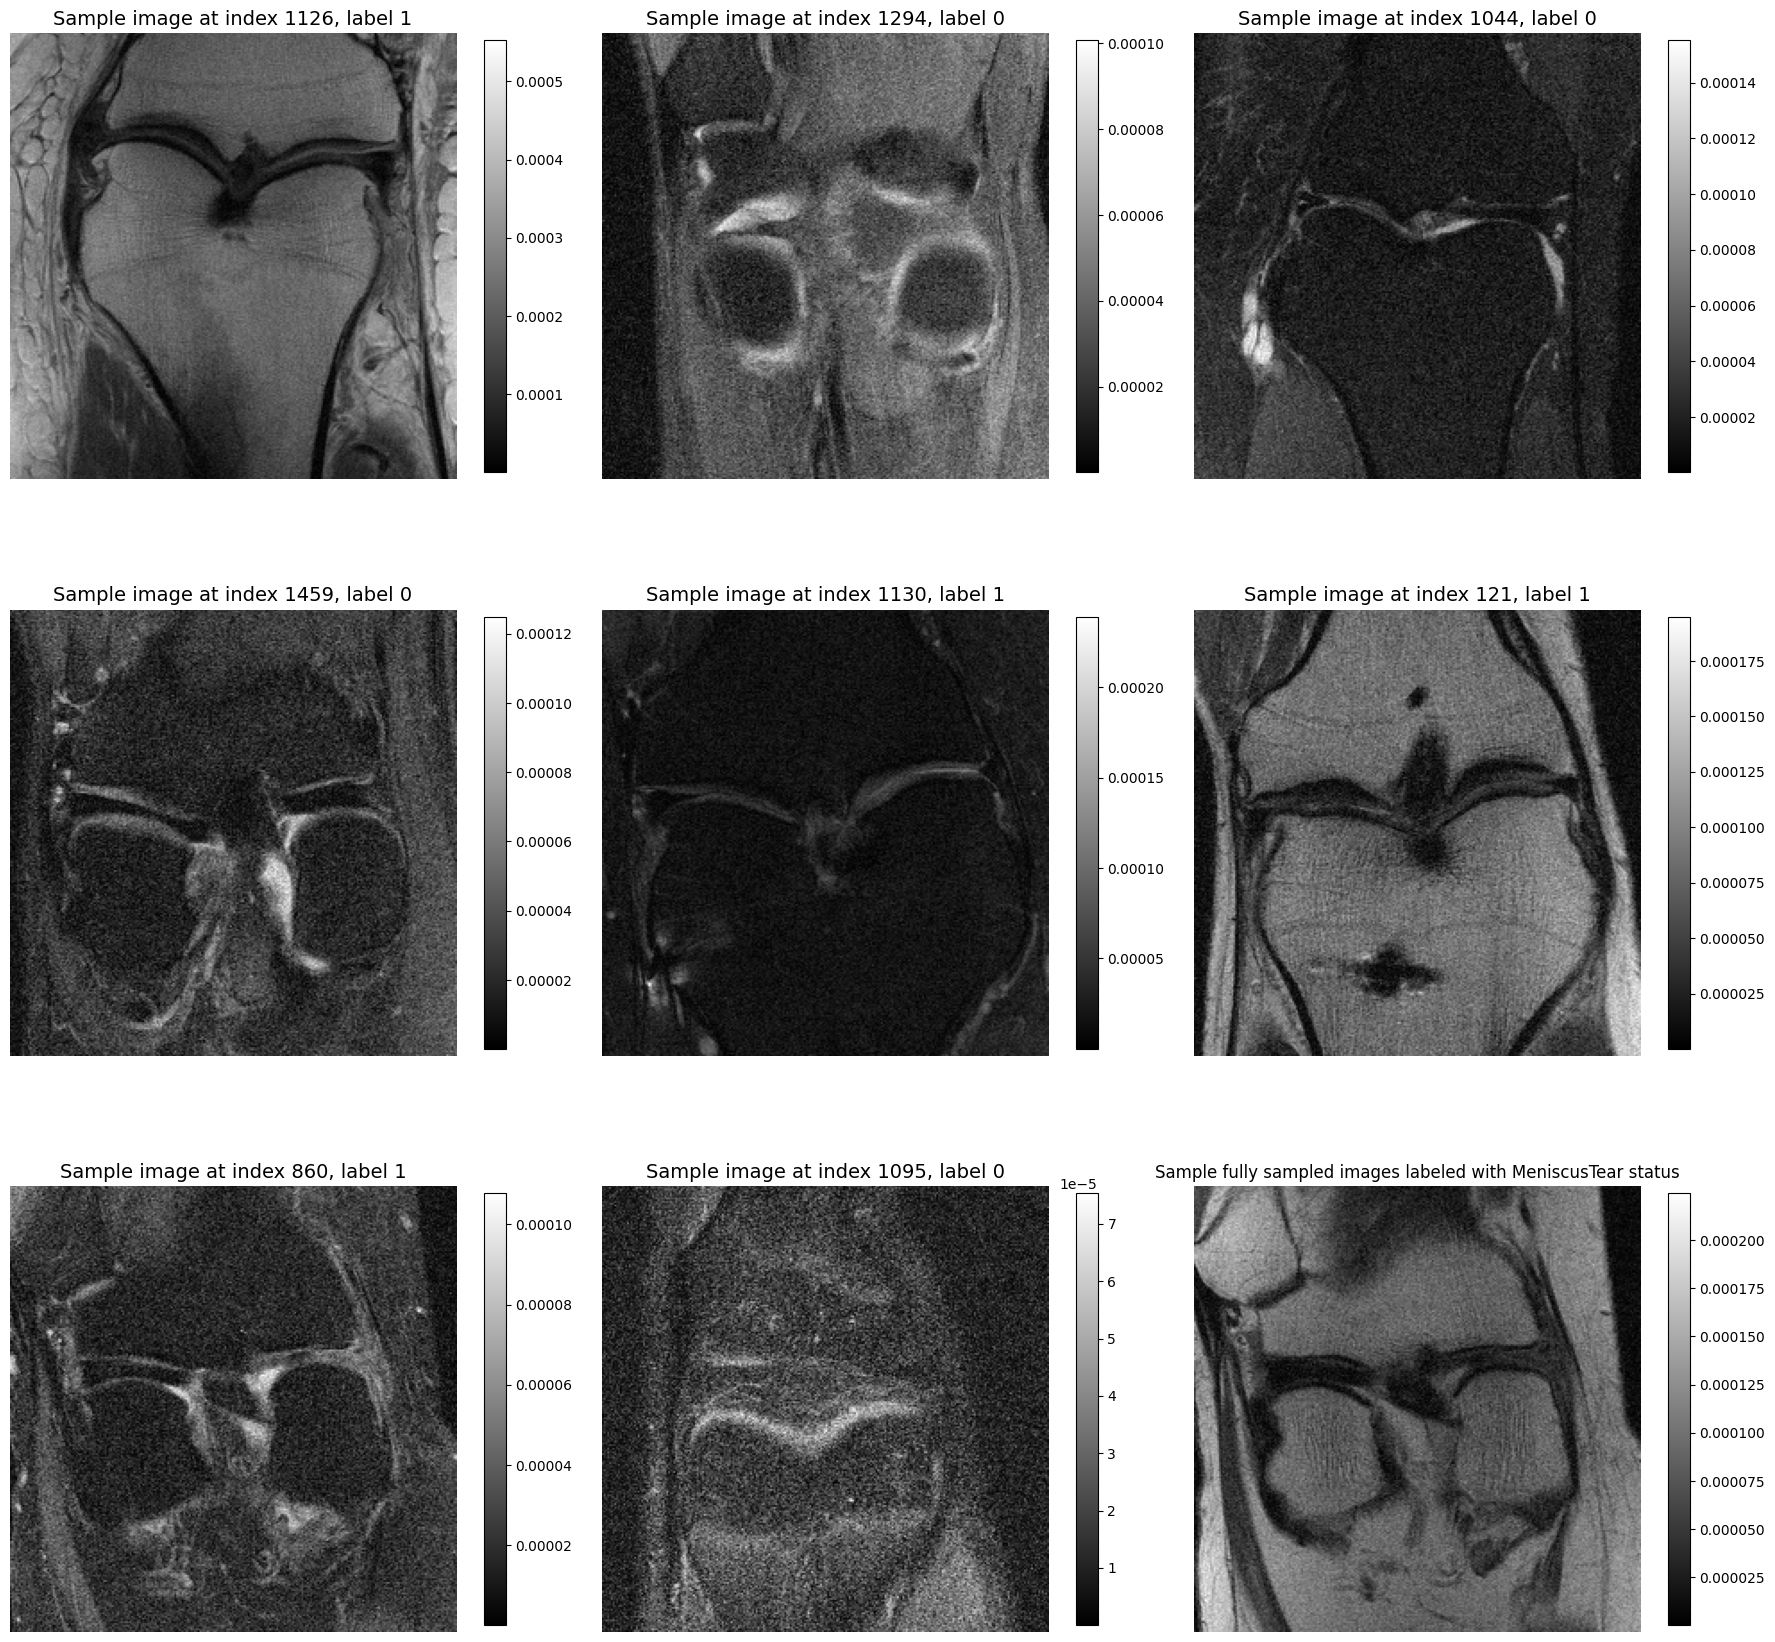

In [3]:
indices = np.random.randint(0, len(train_dataset), 9)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for n, index in enumerate(indices):
    i = n % 3
    j = n // 3

    image, label, mean, std = train_dataset[index]
    image = denorm_image(image, mean, std)
    im = axes[i, j].imshow(image[0], cmap = "gray")
    axes[i, j].set_title(f"Sample image at index {index}, label {label}", fontsize=14)
    axes[i, j].axis('off')
    cbar = fig.colorbar(
        im, 
        ax=axes[i, j], 
        orientation='vertical',
        shrink=0.7 
    )
plt.title("Sample fully sampled images labeled with MeniscusTear status")
plt.tight_layout()
plt.show()
    

#### 3.2 Model loading

With the ground truth loaded, we proceed to instantiate Pipeline C. The model, based on a modified ImageNet-pretrained ResNet-18, requires careful configuration: the first convolutional layer is precisely adjusted for a single input channel (grayscale), and the final fully connected layer is tuned for our binary output status (Meniscus Tear).

We then define all essential operational parameters, including the optimal batch size for maximizing GPU utilization and the number of cores allocated for parallel data loading. These settings enable the creation of the necessary high-throughput data loaders for the training and validation loops.

The model’s quality assurance is managed by a stringent checkpoint callback. This mechanism monitors the performance against the validation set, specifically tracking the Validation Loss. At the end of every training epoch, it saves the weights only if a new best-performing state has been achieved. The entire training process is governed by a simple "Train" flag: if set to True, the fitting process initiates; if set to False, we bypass training and load the stable, optimized weights from their existing local file, immediately placing the model into its mandated fixed-weight deployment state.

In [4]:
pipeline_C = MeniscusTearModel()

batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [5]:
# Create the checkpoint callback
weights_dir = "../models/classifier_tuned"
checkpoint_callback = ModelCheckpoint(
    dirpath=weights_dir, 
    monitor='Val Acc',  # Monitor the validation accuracy we logged
    mode='max',         # Look for the maximum value of 'Val Acc'
    filename='{epoch:02d}-{Val Acc:.4f}',
    save_top_k=1,
    every_n_epochs=1,
    save_weights_only=True
)

trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],
                     max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
if train:
    trainer.fit(pipeline_C, train_loader, val_loader)
    
pipeline_C = MeniscusTearModel.load_from_checkpoint(find_latest_checkpoint(weights_dir))
model_name = "Pipeline C"

#### 3.3 Model Evaluation

Pipeline C, now either newly calibrated or loaded in its frozen state, is ready for its final, rigorous evaluation.

1. Prediction Generation: We first instruct the model to calculate its raw predictions (the output probabilities of the positive label) across the entire validation set. These probability scores are then permanently saved alongside their corresponding true labels.

2. Optimal Thresholding: Classification is an explicit decision, which requires defining a boundary. We calculate the complete array of metrics—accuracy, precision, recall, and F1 score—across a fine-grained range of decision thresholds. The optimal threshold is subsequently defined as the point that yields the maximum F1 score, ensuring the best possible balance between precision and recall for robust, clinical-grade classification performance.

3. Visualization and Final Verdict: The comprehensive results are visualized to provide immediate clarity on the baseline's performance:

- The Confusion Matrix is generated for the optimal threshold, offering a crystal-clear view of True Positives, False Positives, and False Negatives.

- We provide an interactive plot of all calculated metrics versus the threshold, allowing us to dynamically "feel" how different metrics (like recall, often prioritized in medical diagnosis) could be optimized by shifting the decision boundary.

- Finally, we plot the Receiver Operating Characteristic (ROC) Curve and calculate the Area Under Curve (ROC AUC) metric. For a balanced dataset like ours, the ROC AUC provides the single, most robust, and definitive criterion for comparing the overall performance of the full data flows:

⇒ Flow A1-C: Undersampled image is reconstructed with Pipeline A1 (U-Net only) and then classified with Pipeline C.

⇒ Flow A2-C: Undersampled image is reconstructed with Pipeline A2 (U-Net + Data Consistency) and then classified with Pipeline C.

⇒ Flow B-C: Undersampled k-space data is directly reconstructed by Pipeline B (k-space U-Net) before being classified by Pipeline C.

This evaluation establishes the non-negotiable benchmark score for all succeeding reconstruction-classification flows.

In [7]:
preds, labels = calculate_predictions(model = pipeline_C, dataset = val_dataset)

100%|██████████| 316/316 [00:35<00:00,  8.82it/s]


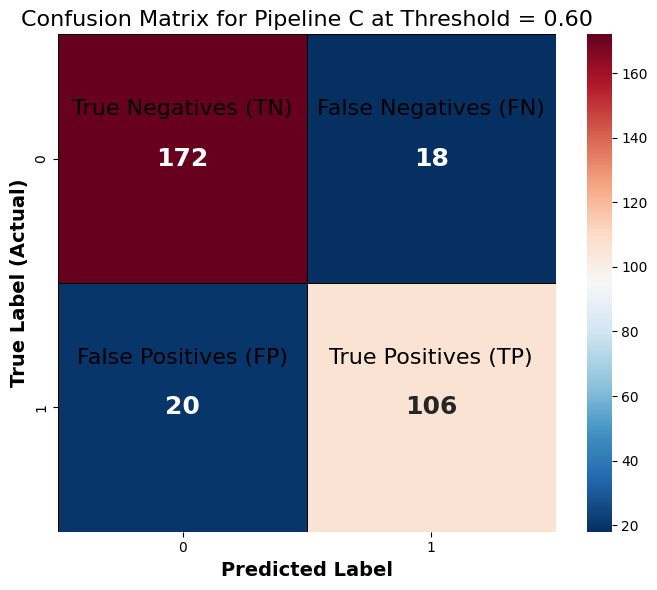

In [8]:
df_metrics, threshold = calculate_classifier_metrics(preds, labels)

show_confusion_matrix(preds, labels, threshold, model_name=model_name)

In [9]:
plot_classifier_metrics_vs_threshold(df_metrics, optimal_threshold = threshold, model_name=model_name)

--- Optimal Metrics
Threshold: 0.600
Precision: 0.855
Recall:    0.841
----------------------------------


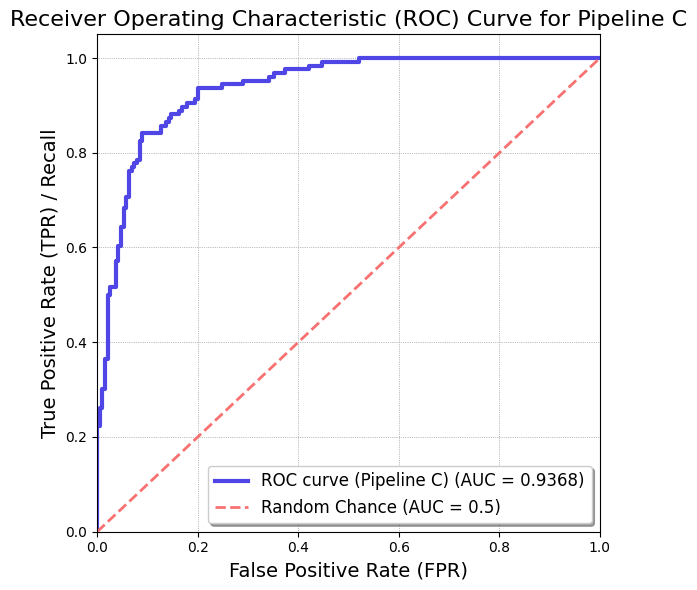

In [10]:
roc_auc = plot_roc_curve_and_auc(preds, labels,model_name=model_name)